In [62]:
import torch
print(f'PyTorch Version: {torch.__version__}.')

import numpy as np
from matplotlib import pyplot as plt

from graphviz import Digraph # pip install graphviz

torch.manual_seed(1337)
np.random.seed(1337)

PyTorch Version: 2.0.1.


In [63]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0 # no effect
        self.label = label

        self._backward = lambda: None # "_backward" stores/caches a function.
        self._prev = set(_children)
        self._op = _op
    #end-def

    def __repr__(self) -> str:
        return f'Value(data={self.data}, grad={self.grad}, label={self.label})'
    #end-def

    def __add__(self, other: object):

        other = other if isinstance(other, Value) else Value(other)

        output = Value(self.data + other.data, (self, other), '+')

        def backward():
            self.grad  += 1.0 * output.grad
            other.grad += 1.0 * output.grad
            # print('inside: __add__')
        #end-def
        output._backward = backward
        '''
        Let's consider,
        (a) "backward()" is function and "_backward" is a variable [class: Value, object: output].
        (b) If we would like to cache the function, we could write "output._backward = backward" as expression.
        (c) However, we could not write "output._backward = backward()" as expression
            because it will automatically call everytime.
        (d) It is a technique to store/cache a function so that we could use when it is required.
        '''

        return output
    #end-def

    def __radd__(self, other: object):
        return self + other
    #end-def

    def __mul__(self, other: object):

        other = other if isinstance(other, Value) else Value(other)

        output = Value(self.data * other.data, (self, other), '*')

        def backward():
            self.grad  += other.data * output.grad
            other.grad += self.data * output.grad
            # print('inside: __mul__')
        #end-def
        output._backward = backward

        return output
    #end-def

    def __rmul__(self, other: object): # other * self
        return self * other
    #end-def

    def __sub__(self, other): # self - other
        return self + (-other)
    #end-def

    def __rsub__(self, other): # other - self
        return other + (-self)
    #end-def

    def __neg__(self):
        return self * -1.0
    #end-def

    def __truediv__(self, other): #self/other
        return self * (other ** -1)
    #end-def

    def __rtruediv__(self, other): # other/self
        return other * (self ** -1)
    #end-def

    def __pow__(self, other: object):
        '''
        # function call: a.pow(3)
        self  ← a # "self"  represents "a" object of class:Value.
        other ← 3 # "other" represents "3"
        '''

        # __o = __o if isinstance(__o, Value) else Value(__o)

        assert isinstance(other, (int, float)), f'The tool accepts "integer" and "float" as exponent value.'

        output = Value(self.data ** other, (self,), f'pow ({self.data}^{other})')

        def backward():
            self.grad += (other * (self.data ** (other - 1.0))) * output.grad
        #end-def
        output._backward = backward

        return output
    #end-def

    def exp(self):
        o = np.exp(self.data)

        output = Value(np.exp(self.data), (self,), 'exp')

        def backward():
            self.grad += o * output.grad # output.data * output.grad --> local derivative x chain rule.
        #end-def
        output._backward = backward

        return output
    #end-def

    # Activation Functions — non-linear functions:
    def tanh(self):
        x = self.data

        o = (np.exp(2.0 * x) - 1.0) / (np.exp(2.0 * x) + 1.0)
        # o = np.tanh(x)

        output = Value(o, (self,), 'tanh')

        def backward():
            self.grad += (1.0-(output.data**2.0)) * output.grad
        #end-def
        output._backward = backward

        return output
    #end-def

    def sigmoid(self):
        x = self.data

        o = 1.0 / (1.0 + np.exp(-x))
        # o = np.tanh(x)

        output = Value(o, (self,), 'sigmoid')

        def backward():
            self.grad += o * (1.0-o) * output.grad
        #end-def
        output._backward = backward

        return output
    #end-def

    def relu(self,):
        x = self.data

        output = Value(x if x>0.0 else 0.0, (self,), 'ReLU')

        def backward():
            self.grad += (1.0 if x>0.0 else 0.0) * output.grad
        #end-def
        output._backward = backward

        return output
    #end-def

    #Differential Calculus:
    def backward(self):
        '''
        self = o
        "self" indecates "o"
        '''

        topo = []
        visited = set()

        def build_topology(v):
            # print('works!')
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topology(child)
                #end-for
                topo.append(v)
            #end-if/else
        #end-def
        build_topology(self)
        # print(topo)

        self.grad = 1.0     # ∂(o)/∂o = 1
        for node in reversed(topo):
            # print(node._backward())
            node._backward()
        #end-for
    #end-def
#end-class

In [64]:
'''
@program: Topological Sort
@author : Andrej Karpathy
@date   : God knows.
'''

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
            #end-for
        #end-if/else
    #end-def
    build(root)
    return nodes, edges
#end-def


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data = %.4f | grad = %.8f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        #end-else/if
    #end-for

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    #end-for

    return dot
#end-def

In [65]:
# a = Value(2.5)

# o = a**3

# o.backward()

# draw_dot(o)

In [66]:
# Epochs = 5
# for i in range(Epochs):
#     o.backward()
# #end-for
# draw_dot(o)

In [123]:
class Neuron:
    def __init__(self, N: int) -> None:
        '''
        arguments:
            N (int): N indicates the number of input (#N).
        return:
            None
        '''
        # self.W = [Value(np.random.uniform(low=-1., high=1.0)) for _ in range(N)]
        # self.b = np.random.uniform(low=-1., high=1.0)

        self.W = [Value(3.5) for _ in range(N)]
        self.b = Value(1.5)

    #end-def
        
    def __repr__(self,) -> str:
        return f'W:{self.W}\nb:{self.b:0.4f}'
    #end-def

    def __call__(self, X):
        # block-1: easier to understand
        # output = 0.0
        # for w, x in zip(self.W, X):
        #     output += (w*x)
        # #end-for
        # output += self.b

        # output = output.relu()   

        # return output
        

        # block-2: Rafsanjani
        output = sum((w*x) for w, x in zip(self.W, X))
        output += self.b
        
        output = output.relu()
        return output

        # block-3: Rafsanjani
        # output = sum((w*x) for w, x in zip(self.W, X)) + self.b
        # output = output.relu()
        # return output
        
        # block-4: Dr. Karpathy uses it.
        # output = sum(((w*x) for w, x in zip(self.W, X)), self.b)
        # output = output.relu()
        # return output
    #end-def
#end-def

Value(data=22.5, grad=0.0, label=)


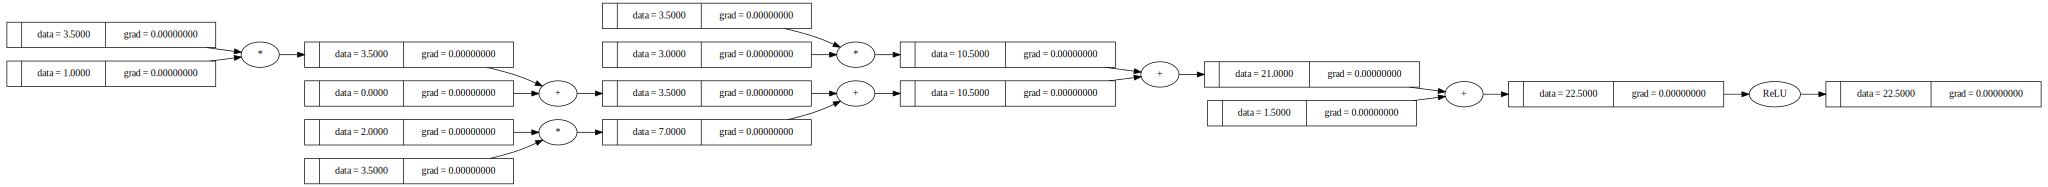

In [124]:
neuron = Neuron(3)
X =[1, 2, 3]
output = neuron(X)
print(output)

draw_dot(output)

# Neuron(3)(X) # Value(data=22.5, grad=0.0, label=)

In [69]:
# n = Neuron(3)
# X = [1, 2, 3]

# o = n(X)

# o.backward()

# draw_dot(o)

In [70]:
# a = Value(10)
# o = a.tanh()

# o.backward()

# draw_dot(o)

In [71]:
# x1 = Value(2.0,  label='x1')
# w1 = Value(-3.0, label='w1')


# x2 = Value(0.0, label='x2')
# w2 = Value(1.0, label='w2')


# b  = Value(6.88, label='b') # When b = 6.88, 1-o^2 = 0.50


# x1w1 = x1*w1; x1w1.label = 'x1*w1'
# x2w2 = x2*w2; x2w2.label = 'x2*w2'


# x1w1x2w2 = x1w1 + x2w2
# x1w1x2w2.label = '(x1*w1) + (x2*w2)'


# n = x1w1x2w2 + b; n.label = 'n'
# # print(n)


# o = n.tanh(); o.label = 'o'
# # print(o)


# # show grads:
# draw_dot(o)

In [72]:
# o.backward()

# draw_dot(o)

In [73]:
# a = Value(15)
# o = a.sigmoid()
# o.backward()

# draw_dot(o)

In [74]:
# x = torch.tensor([10], dtype=float, requires_grad=True)

# # Tanh shows "Vanishing Gradient" (if x>5): gradient of a (∂o/∂x) x: 0.00018158 → 0.0
# # o = torch.tanh(x)


# # Sigmoid shows "Vanishing Gradient" (if x>5): gradient of a (∂o/∂x) x: 0.00004540 → 0.0
# # o = torch.sigmoid(x)
# # Sigmoid gets "zero" more quickly compared to Tanh.


# # However, ReLU shows "No Vanishing Gradient": gradient of a (∂o/∂x) x: 1.00000000
# o = torch.relu(x)
# # That is why, ReLU is popular.

# o.backward()

# print(f'gradient of a (∂o/∂x) x: {x.grad.item():0.8f}')

In [75]:
# Epochs = 5
# for i in range(Epochs):
#     o.backward()
# #end-for

# dot = draw_dot(o)

# dot.render('1-neuron.pdf', view=True)

In [76]:
# n = Neuron(3)

### n.W
# Output:
# [Value(data=3.5, grad=0.0, label=),
#  Value(data=3.5, grad=0.0, label=),
#  Value(data=3.5, grad=0.0, label=)]

### n.b
# Output:
# Value(data=1.5, grad=0.0, label=)

# X = [1,]
# o = n(X)
# draw_dot(o)

In [133]:
class Layer:
    def __init__(self, N_in=3, N_out=4) -> None:
        self.neurons = [Neuron(N_in) for _ in range(N_out)]
    #end-def
        
    def __repr__(self,) -> str:
        return f'Neurons: {self.neurons}'
    #end-def
    
    def __call__(self, X):
        outputs = [neuron(X) for neuron  in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
        # return outputs
    #end-def
#end-def

In [78]:
# X = [1, 2, 3]
# layer = Layer(N_in=3, N_out=4)
# v = []
# for neuron in layer.neurons:
#     v.append(neuron(X))
#     # break

In [79]:
# layer = Layer(3, 4)
# for neuron in layer.neurons:
#     print(neuron.W)

In [80]:
# X =[1, 2, 3]
# layer = Layer(3, 4)
# neurons = layer(X)
# # print(neurons)

# # print(neurons[0])

# # draw_dot(neurons[0])

# for neuron in neurons:
#     # print(neuron)
#     draw_dot(neuron)

In [81]:
# # l = Layer(3, 4)
# # X = [1, 2, 3]

# # l(X)

# # print(o)
# # draw_dot(o)

# # print(l)

# # layer = Layer(2, 3)
# # # this layer has 3 neurons, each neuron has 2 input
# # for neuron in layer.neurons:
# #     print (neuron.w)

# X = [1, 2, 3]
# layer = Layer(3, 4)
# v = layer(X)
# v
# # draw_dot(v)


# # for neuron in layer.neurons:
# #     print(neuron)
# # #end-for

In [82]:
# class MLP:
#     def __init__(self, N_in, N_outs) -> None:
#         sz = [N_in] + N_outs # [3] + [4, 4, 1] → [3, 4, 4, 1]
#         self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(N_outs))]
#     #end-def
    
#     def __repr__(self,) -> str:
#         pass
#     #end-def
    
#     def __call__(self, X):
#         for layer in self.layers:
#             X = layer(X)
#         #end-for
#         return X
#     #end-def
# #end-class

In [120]:
class MLP:
    def __init__(self, N_in, N_outs) -> None:
        size = [N_in] + N_outs
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(N_outs))]
        # print(N_in, N_outs)
    #end-def
    
    def __repr__(self,) -> str:
        pass
    #end-def
    
    def __call__(self, X):
        # print(f'{len(self.layers)}')
        # print(f'{self.layers[0]}')
        for layer in self.layers:
            X = layer(X)
            # print(f'{len(X)}')
        #end-for
        return X
    #end-def
#end-class

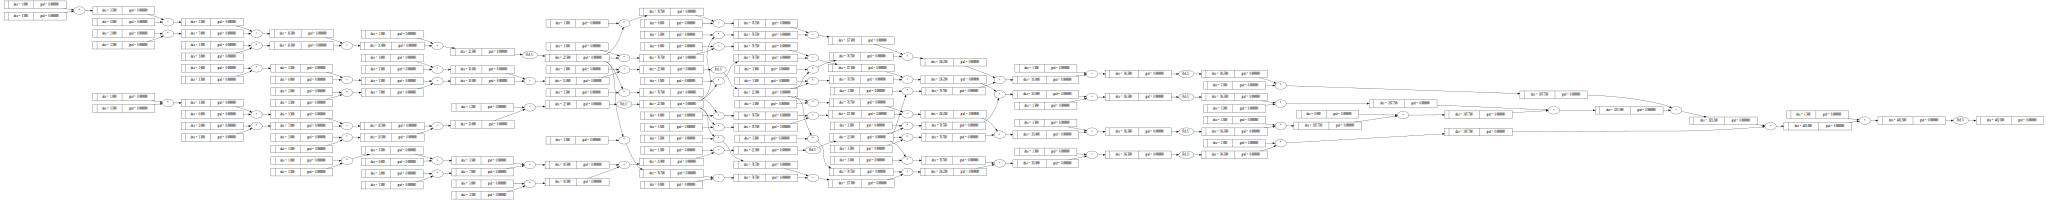

In [125]:
# X = [
#     [1, 2, 3],
#     [1, 2, 3],
#     [1, 2, 3],
#     [1, 2, 3],
#     [1, 2, 3],
# ]
X = [1, 2, 3]
model = MLP(3, [4, 4, 1])
o = model(X)
o
# o.backward()
draw_dot(o[0])

In [159]:
model = MLP(3, [4, 4, 1])

X = [
    [1, 2, 3],
    # [10, 20, 30],
    # [100, 200, 300],
    # [1000, 2000, 3000],
]


# X = [
#     [2,   3,  -1],
#     [3,  -1, 0.5],
#     [0.5, 1,   1],
#     [1,   1,  -1],
# ]

Y = [1, -1]

Yp = [model(x) for x in X]
# print(Ypred)
Yp

[Value(data=4432.5, grad=0.0, label=)]

In [160]:
loss = sum([(y-yp)**2.0 for (y, yp) in zip(Y, Yp)])
loss

Value(data=19638192.25, grad=0.0, label=)

In [161]:
dot = draw_dot(loss)
dot.render('MLP_Network_1_inputs', view=False)

'MLP_Network_1_inputs.svg'

In [87]:
loss = sum([(y-yp)**2.0 for (y, yp) in zip(Y, Yp)])
loss

Value(data=5.46961737029177, grad=0.0, label=)

In [88]:
loss.backward()

In [97]:
# draw_dot(loss)

In [99]:
model.layers[0].neurons[0].W[0]

Value(data=-0.09241375934353813, grad=0.0, label=)

In [100]:
model.layers[0].neurons[0].W[0].grad

0.0

In [169]:
# [3.5, 3.5, 3.5] + [1.5] # [3.5, 3.5, 3.5, 1.5]

v1 = [1, 2, 3]
v2 = [10, 20, 30]
# v.append(1)
v1.extend(v2)
print(v1)

# v1 + v2

[1, 2, 3, 10, 20, 30]


In [170]:
v1 = [1, 2, 3]
v2 = [10, 20, 30]
v1+v2

[1, 2, 3, 10, 20, 30]

In [ ]:
# Fun fact about Python. You can use a sum function to flatten nested lists. 
# l=[['a', 'b', 'c'], ['1', '2'], ['#']]
# sum(l, [])
# Result:
# ['a', 'b', 'c', '1', '2', '#']

In [4]:
# V = [
#     ['a', 'b'],
#     ['1', '2'],
#     ['#']
# ]

V = [
    ['a', 'b'],
    [1, 2],
    ['#']
]

sum(V, [])

['a', 'b', 1, 2, '#']

# GraphViz

In [ ]:
# import graphviz  
dot = Digraph(comment='The Round Table')

dot.node('A', 'A')  
dot.node('B', 'B')
dot.edges(['AB', 'AC', 'AD', 'DB', 'BC'])
dot.node('C', 'C')
dot.node('D', 'D')

dot.edge('B', 'A', constraint='false')

In [ ]:
# print(dot.source)

In [ ]:
dot.render('round-table', view=True)  
# doctest_mark_exe()


'round-table.pdf'

In [12]:
for i in range(10):
    print(i)
#end-forL

0
1
2
3
4
5
6
7
8
9


dd

### learning rate decay:

In [18]:
epochs = 500

for epoch in range(epochs):
    lr = 1- ((0.9*epoch)/100.0)
    print(lr)
#end-for

1.0
0.991
0.982
0.973
0.964
0.955
0.946
0.937
0.9279999999999999
0.919
0.91
0.901
0.892
0.883
0.874
0.865
0.856
0.847
0.838
0.829
0.8200000000000001
0.8109999999999999
0.802
0.793
0.784
0.775
0.766
0.757
0.748
0.739
0.73
0.721
0.712
0.7030000000000001
0.694
0.685
0.6759999999999999
0.667
0.6579999999999999
0.649
0.64
0.631
0.6219999999999999
0.613
0.604
0.595
0.5860000000000001
0.577
0.568
0.5589999999999999
0.55
0.541
0.532
0.5229999999999999
0.514
0.505
0.496
0.487
0.478
0.469
0.45999999999999996
0.45100000000000007
0.44199999999999995
0.43299999999999994
0.42399999999999993
0.41500000000000004
0.406
0.3969999999999999
0.388
0.379
0.37
0.361
0.352
0.34299999999999997
0.33399999999999996
0.32499999999999996
0.31599999999999995
0.30700000000000005
0.29799999999999993
0.2889999999999999
0.28
0.2709999999999999
0.262
0.253
0.24399999999999988
0.235
0.22599999999999998
0.21700000000000008
0.20799999999999996
0.19899999999999995
0.18999999999999995
0.18099999999999994
0.17200000000000004
0

In [ ]:
d